# Getting Started with Kloppy for Soccer Analysis

We will load a single game of event and tracking data from the [Open DFL Dataset (Bassek et al. 2025)](https://www.nature.com/articles/s41597-025-04505-y).

Choose any of the following match ids.

| match_id | home | away |
| --- | --- | --- |
| J03WMX | 1. FC Köln | FC Bayern München |
| J03WN1 | VfL Bochum 1848 | Bayer 04 Leverkusen |
| J03WPY | Fortuna Düsseldorf | 1. FC Nürnberg |
| J03WOH | Fortuna Düsseldorf | SSV Jahn Regensburg |
| J03WQQ | Fortuna Düsseldorf | FC St. Pauli |
| J03WOY | Fortuna Düsseldorf | F.C. Hansa Rostock |
| J03WR9 | Fortuna Düsseldorf | 1. FC Kaiserslautern |

We set the coordinate system to "secondspectrum", meaing the coordinate range will be X = [-pitch_length / 2, +pitch_length / 2] and Y = [-pitch_width / 2, +pitch_width / 2]

In [1]:
from kloppy import sportec

match_id = "J03WN1"

dataset = sportec.load_open_event_data(match_id=match_id, coordinates="secondspectrum")
home_team, away_team = dataset.metadata.teams
f"{home_team} - {away_team}"

'VfL Bochum 1848 - Bayer 04 Leverkusen'

-------
### Metadata

Within the [metadata](broken) we can find a lot of information, for example the `player_id` of each player.

In [2]:
for p in away_team.players:
    print(f"#{p.jersey_no}.", p, " - ", p.player_id)

#1. L. Hrádecký  -  DFL-OBJ-0026NY
#4. Jonathan Tah  -  DFL-OBJ-0001UP
#28. P. Pentz  -  DFL-OBJ-J012D8
#9. S. Azmoun  -  DFL-OBJ-J013O2
#11. N. Amiri  -  DFL-OBJ-0002LI
#22. D. Sinkgraven  -  DFL-OBJ-002G1P
#24. Timothy Fosu-Mensah  -  DFL-OBJ-002GNP
#19. M. Diaby  -  DFL-OBJ-002G02
#32. A. Azhil  -  DFL-OBJ-002G57
#5. M. Bakker  -  DFL-OBJ-J01B8R
#12. Edmond Tapsoba  -  DFL-OBJ-002GAR
#25. Exequiel Palacios  -  DFL-OBJ-002G8H
#47. A. Aourir  -  DFL-OBJ-002GFO
#43. L. Köhl  -  DFL-OBJ-002GH4
#30. Jeremie Frimpong  -  DFL-OBJ-002GOI
#27. Florian Wirtz  -  DFL-OBJ-002GBK
#23. A. Hložek  -  DFL-OBJ-J01G0J
#18. Noah Mbamba  -  DFL-OBJ-J01K4C
#21. A. Adli  -  DFL-OBJ-J01KDN
#31. Madi Monamay  -  DFL-OBJ-J01QRV


-----

### Filtering

First we'll filter out all actions by Florian Wirtz ("DFL-OBJ-002GBK")

In [3]:
player_id = "DFL-OBJ-002GBK"

player_events = dataset.filter(
    lambda event: (
        str(event.player.player_id) == player_id if event.player is not None else False
    )
)
player_events

<EventDataset record_count=72>

We can obtain a single `player` object from a team calling `get_player_by_id()`

In [4]:
player = away_team.get_player_by_id(player_id)
player

Player(player_id='DFL-OBJ-002GBK', team=Team(team_id='DFL-CLU-00000B', name='Bayer 04 Leverkusen', ground=away, starting_formation=None, formations=<TimeContainer>, players=[Player(player_id='DFL-OBJ-0026NY', team=..., jersey_no=1, name='L. Hrádecký', first_name='Lukáš', last_name='Hrádecký', starting=True, starting_position=<PositionType.Goalkeeper: ('Goalkeeper', 'GK', None)>, positions=TimeContainer[PositionType]({'P1T00:00': <PositionType.Goalkeeper: ('Goalkeeper', 'GK', None)>}), attributes={}), Player(player_id='DFL-OBJ-0001UP', team=..., jersey_no=4, name='Jonathan Tah', first_name='Jonathan Glao', last_name='Tah', starting=True, starting_position=<PositionType.RightCenterBack: ('Right Center Back', 'RCB', 'CenterBack')>, positions=TimeContainer[PositionType]({'P1T00:00': <PositionType.RightCenterBack: ('Right Center Back', 'RCB', 'CenterBack')>}), attributes={}), Player(player_id='DFL-OBJ-J012D8', team=..., jersey_no=28, name='P. Pentz', first_name='Patrick', last_name='Pentz',

--------
### Heatmap

Now, using the wonderful [mplsoccer](https://mplsoccer.readthedocs.io) package we can plot a heatmap of all Wirtz' events.

In [5]:
%pip install mplsoccer --quiet


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


First, we plot all of Wirtz' actions with the default orientation setting for this dataset.

In [6]:
dataset.metadata.orientation

away-home

Below, we graph the x and y coordinates from each event and pass them into `mplsoccer`'s built in kdeplot function.

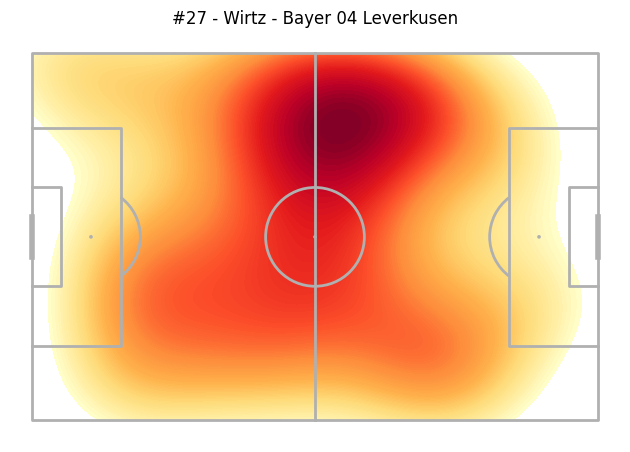

In [7]:
from mplsoccer import Pitch


def heatmap(xs, ys):
    pitch = Pitch(
        line_zorder=2,
        pitch_type="secondspectrum",
        pitch_length=dataset.metadata.pitch_dimensions.pitch_length,
        pitch_width=dataset.metadata.pitch_dimensions.pitch_width,
    )
    fig, ax = pitch.draw()
    ax.set_title(f"#{player.jersey_no} - {player.last_name} - {player.team.name}")
    pitch.kdeplot(xs, ys, ax=ax, cmap="YlOrRd", fill=True, levels=100)


xs = [event.coordinates.x for event in player_events if event.coordinates is not None]
ys = [event.coordinates.y for event in player_events if event.coordinates is not None]

heatmap(xs, ys)

-------
### Transform
Now, we transform the `player_events` into attacking left to right by using `"ACTION_EXECUTING_TEAM"` as the new orientation.

Note: For tracking data this same behaviour is accomplished by setting `to_orientation="BALL_OWNING_TEAM"` instead.

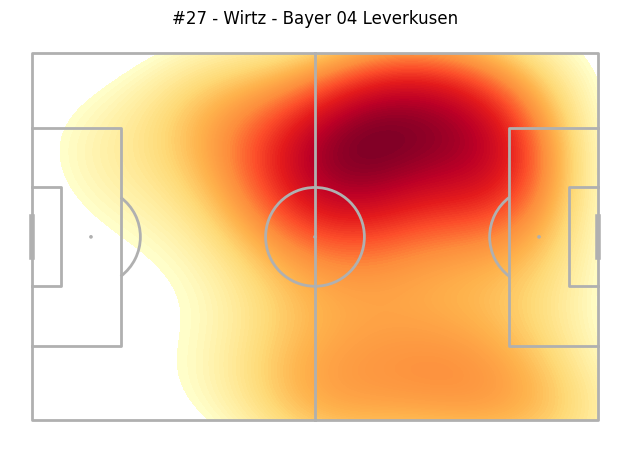

In [8]:
transformed_events = player_events.transform(to_orientation="ACTION_EXECUTING_TEAM")

xs = [
    event.coordinates.x for event in transformed_events if event.coordinates is not None
]
ys = [
    event.coordinates.y for event in transformed_events if event.coordinates is not None
]

heatmap(xs, ys)

------
### To DataFrame

To do further analyis we can use the built in `to_df()` function to convert our kloppy dataset into a Pandas or Polars dataframe. We accomplish this by specifying either `engine="polars"` or `engine="pandas"`. 

Note: An error will be thrown if you do not have pandas or polars installed. 

Simply calling `dataset.to_df()` results in a default output, but we can modify how the resulting dataframe looks as shown in the code below.


In [9]:
shots_and_key_passes = (
    dataset
    # filter for shots
    .filter("shot")
    # convert to Polars dataframe
    .to_df(
        "player_id",
        lambda event: {
            "player_name": str(event.player),
            "is_goal": event.result.is_success,
        },
        "coordinates_*",
        key_pass=lambda event: str(event.prev("pass").player),
        team=lambda event: str(event.team),
        engine="polars",
    )
)

-----
### Frame and Event

### Load Tracking Dataset

We'll load the tracking data, this might take a while...

In [10]:
tracking_dataset = sportec.load_open_tracking_data(
    match_id=match_id, coordinates="secondspectrum"
)
home_team, away_team = dataset.metadata.teams
f"{home_team} - {away_team}"

'VfL Bochum 1848 - Bayer 04 Leverkusen'

Transform the `tracking_dataset` to also attack from left to right. Similar to how to transformed the events to `"ACTION_EXECUTING_TEAM"`. For tracking data we have to use `"BALL_OWNING_TEAM"`

In [11]:
tracking_dataset = tracking_dataset.transform(to_orientation="BALL_OWNING_TEAM")

### Find Nearest Frame

The event timestamps are recorded as `timedelta` objects. They do not exactly match the tracking timestamps `timedelta`, because for tracking data we have a frame at exactly every (1 / frame_rate) frames (i.e. at 0.04 when fps is 25). 

To align them, we round the event frame timestamp to the nearest 0.04 and then find the matching frame of tracking data for this timestamp.

In [14]:
from datetime import datetime, timedelta


def round_to_nearest_frame(seconds):
    fps = 1 / tracking_dataset.metadata.frame_rate
    return timedelta(seconds=round(seconds / fps) * fps)


shot_event = dataset.filter("shot")[0]

shot_frames = tracking_dataset.filter(
    lambda frame: frame.timestamp
    == round_to_nearest_frame(shot_event.timestamp.total_seconds())
)
# a sanity check to make sure we have a frame for the shot
assert len(shot_frames.records) == 1

shot_frame = shot_frames.records[0]

### Plot Frame and Event

Plot the event and tracking data on a single image. 

1. Collect all players `x`, `y` and `colors`.
2. Instantiate a `mplsoccer` `Pitch`
3. Add a title
4. Add the event location and mark it with an 'x' using `plt.scatter`
5. Add the players from the tracking frame using `plt.scatter`

Note: Team colors are taken from [Team Color Codes](https://teamcolorcodes.com)

In [18]:
from kloppy.domain import Ground

HOME_COLOR = "#005CA9"
AWAY_COLOR = "#E32221"

xs = [
    shot_frame.players_coordinates.get(player).x for player in shot_frame.players_data
]
ys = [
    shot_frame.players_coordinates.get(player).y for player in shot_frame.players_data
]
colors = [
    HOME_COLOR if player.team.ground == Ground.HOME else AWAY_COLOR
    for player in shot_frame.players_data
]

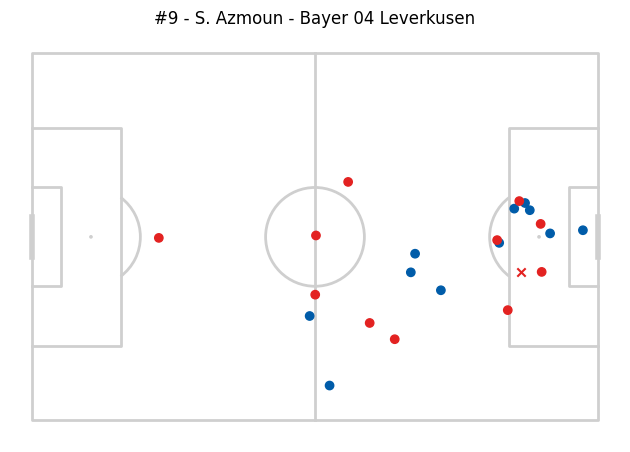

In [19]:
pitch = Pitch(
    line_color="#cfcfcf",
    line_zorder=1,
    pitch_type="secondspectrum",
    pitch_length=dataset.metadata.pitch_dimensions.pitch_length,
    pitch_width=dataset.metadata.pitch_dimensions.pitch_width,
)
fig, ax = pitch.draw()
# Set the title
ax.set_title(
    f"#{shot_event.player.jersey_no} - {shot_event.player} - {shot_event.team.name}"
)
# Add an 'X' to indicate the location of the shot
pitch.scatter(
    shot_event.coordinates.x,
    shot_event.coordinates.y,
    ax=ax,
    marker="x",
    color=HOME_COLOR if shot_event.player.team.ground == Ground.HOME else AWAY_COLOR,
)

xs = [
    shot_frame.players_coordinates.get(player).x for player in shot_frame.players_data
]
ys = [
    shot_frame.players_coordinates.get(player).y for player in shot_frame.players_data
]
# Add x and y coordinates of the players
pitch.scatter(xs, ys, ax=ax, color=colors)

-----
### Custom Events
Whenever we want to obtain additional information from the raw events that is not currently supported out-of-the-box by Kloppy, we can create our own custom events.

Here we first create a new `SportecShotEvent` and then we create a `SportecEventFactory` that helps us by parsing the 'xG' and 'DistanceToGoal' values from the raw Sportec event.

We now pass this new `event_factory` to our data loader and we reload the data that now also includes 'xg' and 'distance_to_goal'.

Note: These custom events require a different approach for each data provider. You can find all additional information in the `raw_event` inside the `build_shot` functionality.


In [28]:
from kloppy.domain import EventFactory, create_event, ShotEvent
from dataclasses import dataclass
from typing import Optional


@dataclass(repr=False)
class SportecShotEvent(ShotEvent):
    xg: Optional[float] = None
    distance_to_goal: Optional[float] = None

    @property
    def inverted_xg(self) -> Optional[float]:
        if self.xg is not None:
            return 1 - self.xg
        else:
            return None

    def __str__(self):
        return f"<Shot event_id='{self.event_id}' time='{self.time}' player='{self.player}' xg={self.xg} distance_to_goal={self.distance_to_goal} result='{self.result}'>"


class SportecEventFactory(EventFactory):
    def build_shot(self, raw_event, **kwargs) -> ShotEvent:
        xg = raw_event["xG"]
        distance_to_goal = raw_event["DistanceToGoal"]

        if xg is not None:
            xg = float(xg)
        if distance_to_goal is not None:
            distance_to_goal = float(distance_to_goal)

        return create_event(
            SportecShotEvent,
            xg=xg,
            distance_to_goal=distance_to_goal,
            raw_event=raw_event,
            **kwargs,
        )


event_dataset = sportec.load_open_event_data(
    match_id=match_id,
    coordinates="secondspectrum",
    event_factory=SportecEventFactory(),  # Use our custom EventFactory
)
shots = event_dataset.filter("shot")

for shot in shots[:3]:
    print(shot)

<Shot event_id='18226900000020' time='P1T00:52' player='S. Azmoun' xg=0.0354 distance_to_goal=16.15 result='BLOCKED'>
<Shot event_id='18226900000023' time='P1T00:57' player='M. Diaby' xg=0.0426 distance_to_goal=14.45 result='BLOCKED'>
<Shot event_id='18226900000027' time='P1T01:50' player='S. Azmoun' xg=0.0785 distance_to_goal=11.28 result='BLOCKED'>


Now we can go ahead and create a Polars dataframe with cumulative xG values per player, and the average distance to goal.

In [30]:
import polars as pl

shots_with_xg = (
    event_dataset
    # filter for shots
    .filter("shot")
    # convert to Polars dataframe
    .to_df(
        "player_id",
        lambda event: {
            "player_name": str(event.player),
        },
        team=lambda event: str(event.team),
        xg=lambda event: event.xg,
        distance_to_goal=lambda event: event.distance_to_goal,
        engine="polars",
    )
    .group_by("player_id", "player_name", "team")
    .agg(
        xg_total=pl.sum("xg"),
        avg_dist_to_goal=pl.mean("distance_to_goal"),
        total=pl.len()
    )
    .sort("xg_total", descending=True)
)
shots_with_xg

player_id,player_name,team,xg_total,avg_dist_to_goal,total
str,str,str,f64,f64,u32
"""DFL-OBJ-0027LO""","""P. Förster""","""VfL Bochum 1848""",0.8438,7.9,1
"""DFL-OBJ-0027FG""","""T. Asano""","""VfL Bochum 1848""",0.3411,12.935,2
"""DFL-OBJ-0000YV""","""P. Hofmann""","""VfL Bochum 1848""",0.2926,15.35,3
"""DFL-OBJ-002GOI""","""Jeremie Frimpong""","""Bayer 04 Leverkusen""",0.2279,10.47,1
"""DFL-OBJ-0002LI""","""N. Amiri""","""Bayer 04 Leverkusen""",0.2106,15.345,2
…,…,…,…,…,…
"""DFL-OBJ-J01AQV""","""M. Broschinski""","""VfL Bochum 1848""",0.0679,17.56,1
"""DFL-OBJ-000199""","""A. Losilla""","""VfL Bochum 1848""",0.0405,24.84,1
"""DFL-OBJ-002G8H""","""Exequiel Palacios""","""Bayer 04 Leverkusen""",0.0239,22.83,1
